In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from scipy import stats
from collections import defaultdict
import tqdm
import seaborn as sns


source_all = pd.read_csv('../../data/source_all.csv')
thre = 0.1  # {0.1,0.2}
poli_range = [-2,-thre, thre-0.00000001,2]
suffix = str(thre)
i2poli = source_all[source_all['manual']<90]
i2poli = i2poli[['i','manual']]
i2poli.rename(columns={'manual':'poli'},inplace=True)

i2poli, source_all = i2poli.set_index('i'), source_all.set_index('i')
with open('../get_effect/result/mind/policy_effect_o2j.pkl', 'rb') as file:
    peo2j = pickle.load(file)
news = pd.read_csv('../../data/all_news.csv').set_index('i')

with open('../../data/i2cdf.pkl', 'rb') as file:
    i2c = pickle.load(file)
cate_arr,cate_dict = i2c.values.squeeze(),defaultdict(int)
for cateid in cate_arr:
    cate_dict[cateid] += 1
VALUES = np.array(list(cate_dict.values()))
sorted_indices = np.argsort(VALUES)[-10:]
LABELS = np.array(['Lifestyle', 'Health', 'News', 'Autos', 'TV', 'Food&Drink', 'Travel', 'Sports', 'Finance', 'Weather', 'Movies', 'Entertainment', 'Video', 'Kids', 'Music', 'North America'])

In [2]:
ave_effect_arr, num_arr, left_list, right_list, mid_list = np.zeros((16,3)), np.zeros((16,3)), [], [], []
for a in tqdm.tqdm(list(range(16))):
    for b in [0,1,2]:
        v_effect = []
        for j in peo2j:
            if j not in i2poli.index or i2poli.loc[j,'poli'] <= poli_range[b] or i2poli.loc[j,'poli'] > poli_range[b+1] or source_all.loc[j,'click']<1:
                continue
            for v in peo2j[j]:
                if v not in i2c.index or i2c.loc[v][0]!= a:
                    continue
                v_effect.append(peo2j[j][v])
        ave_effect_arr[a,b], num_arr[a,b] = np.mean(v_effect), len(v_effect)
        if b==0:
            left_list.extend(v_effect)
        elif b==2:
            right_list.extend(v_effect)
        else:
            mid_list.extend(v_effect)

100%|██████████| 16/16 [09:45<00:00, 36.58s/it]


***** Wilcoxon-Mann-Whitney test *****
pval_left_right 7.406275341884555e-14
pval_left_mid 0.03326561441874809
pval_mid_right 5.12293084277968e-08
0.0 0.0 0.0


<Figure size 640x480 with 0 Axes>

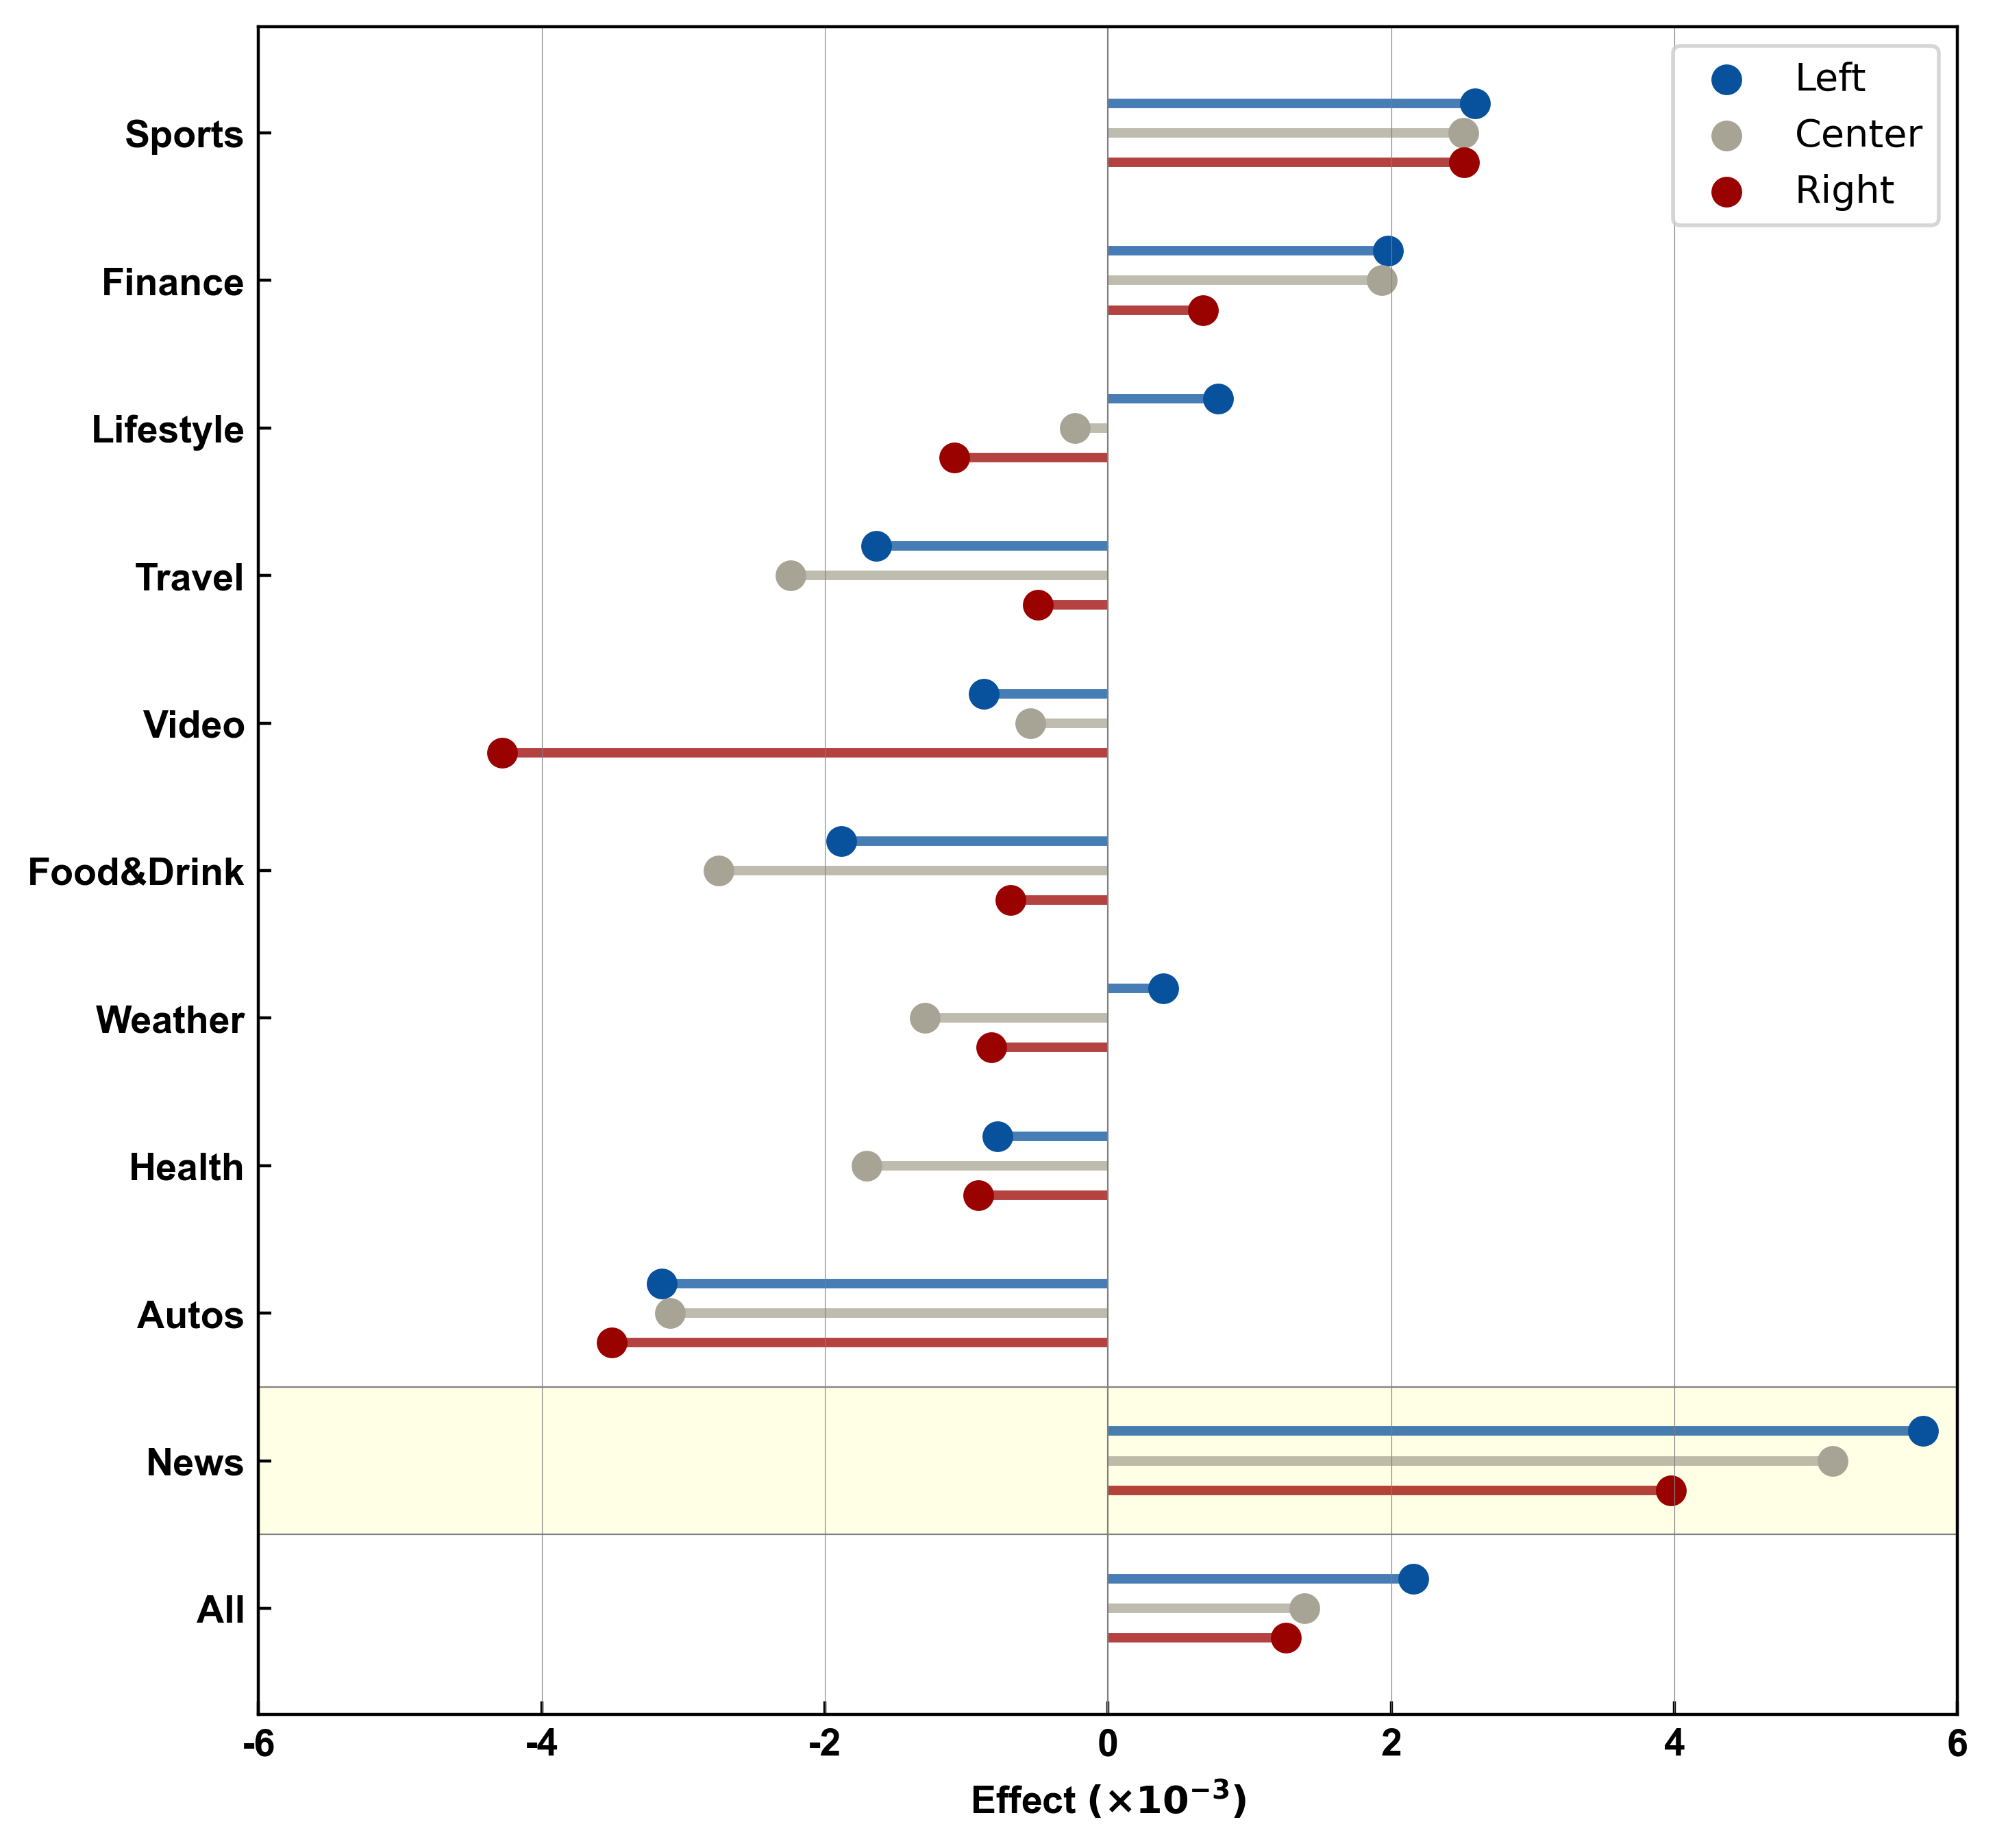

In [3]:
print('***** Wilcoxon-Mann-Whitney test *****')
pval_left_right = tuple(stats.mannwhitneyu(left_list, right_list, alternative='greater'))[1]
print('pval_left_right',pval_left_right)
pval_left_mid = tuple(stats.mannwhitneyu(left_list, mid_list, alternative='greater'))[1]
print('pval_left_mid',pval_left_mid)
pval_mid_right = tuple(stats.mannwhitneyu(mid_list, right_list, alternative='greater'))[1]
print('pval_mid_right',pval_mid_right)
print(np.median(left_list),np.median(mid_list),np.median(right_list))

plt.figure()
fig, ax = plt.subplots(figsize=(8,8),dpi=400)
rearranged_indices = [8,0,1,2,3,4,5,6,7,9]
ax.axhspan(0.5,1.5,facecolor='yellow',alpha=0.1)

left_effect_arr = ave_effect_arr[sorted_indices,0][rearranged_indices]
ax.hlines(y=[i+1.2 for i in range(10)], xmin=0, xmax=left_effect_arr, color='#08519c', alpha=0.75, ls='-', lw=2.5)
ax.scatter(left_effect_arr, [i+1.2 for i in range(10)], color='#08519c', s=50, alpha=1, label='Left')

mid_effect_arr = ave_effect_arr[sorted_indices,1][rearranged_indices]
ax.hlines(y=[i+1 for i in range(10)], xmin=0, xmax=mid_effect_arr, color='#a8a495', alpha=0.75, ls='-', lw=2.5)
ax.scatter(mid_effect_arr, [i+1 for i in range(10)], color='#a8a495', s=50, alpha=1, label='Center')

right_effect_arr = ave_effect_arr[sorted_indices,2][rearranged_indices]
ax.hlines(y=[i+0.8 for i in range(10)], xmin=0, xmax=right_effect_arr, color='#9a0200', alpha=0.75, ls='-', lw=2.5)
ax.scatter(right_effect_arr, [i+0.8 for i in range(10)], color='#9a0200', s=50, alpha=1, label='Right')
ax.legend(loc='upper right')

ax.hlines(y=0.2, xmin=0, xmax=np.mean(left_list), color='#08519c', alpha=0.75, ls='-', lw=2.5)
ax.scatter(np.mean(left_list), 0.2, color='#08519c', s=50, alpha=1)
ax.hlines(y=0, xmin=0, xmax=np.mean(mid_list), color='#a8a495', alpha=0.75, ls='-', lw=2.5)
ax.scatter(np.mean(mid_list), 0, color='#a8a495', s=50, alpha=1)
ax.hlines(y=-0.2, xmin=0, xmax=np.mean(right_list), color='#9a0200', alpha=0.75, ls='-', lw=2.5)
ax.scatter(np.mean(right_list), -0.2, color='#9a0200', s=50, alpha=1)

if poli_range[1] == -0.2:
    ax.set_xlim((-0.009,0.009))
    ax.set_xticks(np.arange(-0.009,0.0091,0.003),labels=['-9','-6','-3','0','3','6','9'])
    ax.hlines(y=0.5, xmin=-0.009, xmax=0.009, color='grey', ls='-', lw=0.4)
    ax.hlines(y=1.5, xmin=-0.009, xmax=0.009, color='grey', ls='-', lw=0.4)
    for x in [-0.006,-0.003,0.003,0.006]:
        plt.axvline(x=x, c="grey", ls="-", lw=0.2)
    plt.axvline(x=0, c="grey", ls="-", lw=0.4)
else:
    ax.set_xlim((-0.006,0.006))
    ax.set_xticks(np.arange(-0.006,0.0061,0.002),labels=['-6','-4','-2','0','2','4','6'])
    ax.hlines(y=0.5, xmin=-0.006, xmax=0.006, color='grey', ls='-', lw=0.4)
    ax.hlines(y=1.5, xmin=-0.006, xmax=0.006, color='grey', ls='-', lw=0.4)
    for x in [-0.004,-0.002,0.002,0.004]:
        plt.axvline(x=x, c="grey", ls="-", lw=0.2)
    plt.axvline(x=0, c="grey", ls="-", lw=0.4)

ax.set_yticks([i for i in range(11)], ['All']+list(LABELS[sorted_indices][rearranged_indices]))
ax.set_xlabel(r'Effect $\mathbf{(\times 10^{-3})}$', fontproperties='Arial', fontweight='bold')
# ax.set_title('Top 10 Categories of All Articles ({})'.format(mode),loc='left')
plt.yticks(fontproperties='Arial', size=10, weight='bold')  # 设置大小及加粗
plt.xticks(fontproperties='Arial', size=10, weight='bold')
plt.tick_params(direction='in')

if poli_range[1] == -0.2:
    plt.savefig('./figures/cate_vs_lcr_{}_S5A.pdf'.format(suffix), dpi=400,bbox_inches='tight',pad_inches=0)
else:
    plt.savefig('./figures/cate_vs_lcr_{}_2A.pdf'.format(suffix), dpi=400,bbox_inches='tight',pad_inches=0)
plt.show()